# Building Multimodal Model

In [56]:
cd ..

e:\


In [57]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [58]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [59]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [60]:
path_img = path/'data_image'

In [61]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [62]:
#reading csv files and doing initial necessary processing
data_info_text_image,test_data_info_text_image = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


E:\CrisisMMD-MMA\notebooks\informative_text_image_combined_Resnet50+AWD_LSTM.ipynb

In [63]:
print(f"shape of data: {data_info_text_image.shape}\n")
print(f"train set: {data_info_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_text_image['is_valid'].value_counts()[1]}")
print("="*50)
print(f"shape of test data: {test_data_info_text_image.shape}\n")

shape of data: (15844, 10)

train set: 13607
valid set: 2237
shape of test data: (2237, 9)



In [2]:
data_lm = get_text_data_for_language_model(data_info_text_image,path)

NameError: name 'get_text_data_for_language_model' is not defined

In [ ]:
# importing pretrained AWD_LSTM model and making learner object consist of data,model for training
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_info_text_image,path,vocab=data_lm.vocab)
test_data_clas = get_test_text_data(test_data_info_text_image,path,vocab=data_lm.vocab)

In [ ]:
# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [ ]:
#importing pretrained AWD-LSTM model and making learner object consist of data,model,metrics and callbacks for training
learn_clas = text_classifier_learner(data_clas, AWD_LSTM,
                                     drop_mult=0.5,metrics=[accuracy,
                                                    Precision(average='macro'),Precision(average='weighted'),
                                                    Recall(average='macro'),Recall(average='weighted'),
                                                    FBeta(average='macro',beta=1),FBeta(average='weighted',beta=1)])

In [ ]:
import os
print(os.listdir(learn_clas.path/learn_clas.model_dir))


['best.pth', 'BEST_HUMANITARIAN_MODEL_INTERMEDIATE_FUSION(RESNET50+AWD_LSTM).pth', 'BEST_INFORMATIVE_MODEL_INTERMEDIATE_FUSION(RESNET50+AWD_LSTM).pth', 'fine_tuned_enc_human(AWD_LSTM).pth', 'fine_tuned_enc_human.pth', 'fine_tuned_enc_info(AWD_LSTM).pth', 'fine_tuned_enc_info.pth', 'Humanitarian_image_only(RESNET50).pth', 'Humanitarian_text_only(AWD_LSTM).pth', 'Humanitarian_text_only.pth', 'Informative_image_only(RESNET50).pth', 'Informative_text_only(AWD_LSTM).pth', 'Informative_text_only.pth', 'README.md', 'tmp.pth']


In [ ]:
# laoding encoder for classification
learn_clas.load_encoder('fine_tunedk_enc_info')
# learn_clas.load_encoder('fine_tuned_enc_info(AWD_LSTM)')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (13607 items)
x: TextList
xxbos pls share were xxunk wildfire response recovery info here,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via
y: CategoryList
informative,informative,informative,informative,informative
Path: \notebooks\MultimodalTweetsClassification;

Valid: LabelList (2237 items)
x: TextList
xxbos iran earthquake damage put at over bn pounds international,xxbos we ve lost track of how many xxunk teams have helped so proud of our church harvey,xxbos the gym above xxunk got destroyed the xxunk wall got blown out hurricanemaria,xxbos famous xxunk xxunk xxunk for xxunk in florida keys during irma,xxbos californias xxunk fire in xxunk captured in pictures and videos xxunk
y: CategoryList
informative,informative,informative,inform

In [ ]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_info_text_image,path,224)
test_data_img = get_test_image_data(test_data_info_text_image,path,224)

In [ ]:
# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [ ]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [ ]:
# learn_img.model

In [ ]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [ ]:
# learn_clas.model

In [ ]:
learn_clas.model[-1].layers = learn_clas.model[-1].layers[:-3]
# learn_clas.model

In [ ]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

In [ ]:
# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [ ]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [ ]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [ ]:
(x1,x2),y = next(iter(data.valid_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 26])
Shape dependent var: torch.Size([16])


In [ ]:
lin_layers = [512+50, 2]
ps = 0.8
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps)

In [ ]:
#making layer groupes and creating learner object for training

loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*flatten_model(learn_clas.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[3])),
                nn.Sequential(*(flatten_model(learn_clas.layer_groups[4]) + 
                                flatten_model(model.mod_img) +
                                flatten_model(model.layers)))]
# layer_groups=layer_groups


model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [ ]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


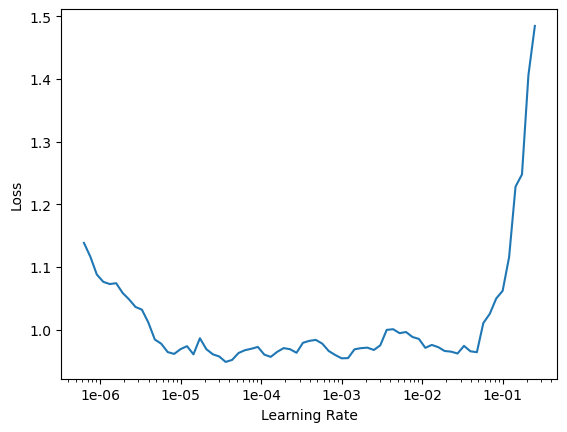

In [ ]:
learn.recorder.plot()

In [ ]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(3,8e-5, moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 21233664 bytes. Buy new RAM!


In [ ]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

In [ ]:
# learn.freeze_to(-3)
# learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

In [ ]:
# learn.unfreeze()
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

In [ ]:
# # training all layer's of the model and saving the best one 
# learn.fit_one_cycle(10, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1,
#                     callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

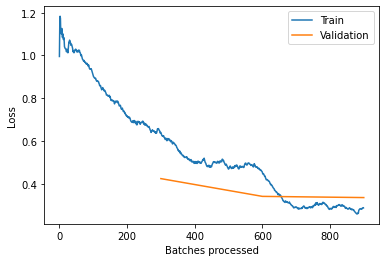

In [ ]:
# making interpretation on test split
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

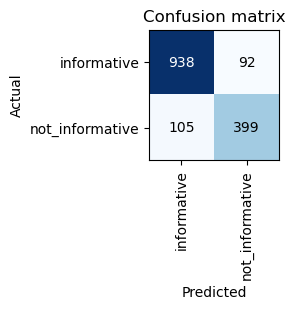

In [ ]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [ ]:
# making interpretation on test split
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Test)

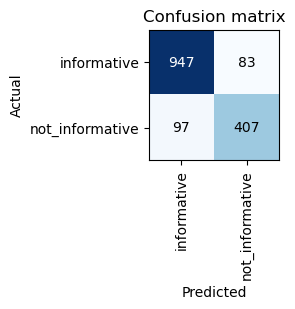

In [ ]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [ ]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.3114534,
 tensor(0.8709),
 tensor(0.8568),
 tensor(0.8697),
 tensor(0.8476),
 tensor(0.8709),
 tensor(0.8519),
 tensor(0.8701)]

In [ ]:
#making on validation set to use it classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.89      0.92      0.91      1056
not_informative       0.82      0.78      0.80       517

       accuracy                           0.87      1573
      macro avg       0.86      0.85      0.85      1573
   weighted avg       0.87      0.87      0.87      1573



In [ ]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.32119757,
 tensor(0.8827),
 tensor(0.8689),
 tensor(0.8820),
 tensor(0.8635),
 tensor(0.8827),
 tensor(0.8661),
 tensor(0.8822)]

In [ ]:
#making predictions on test set to use it in classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.91      0.92      0.91      1030
not_informative       0.83      0.81      0.82       504

       accuracy                           0.88      1534
      macro avg       0.87      0.86      0.87      1534
   weighted avg       0.88      0.88      0.88      1534



In [ ]:
learn.save("Informative_best")